In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import string
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from assnat.params import *
from assnat.clean import complete_preproc
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Masking, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import Word2Vec

from transformers import AutoTokenizer

import time, os
from collections.abc import Callable
from tensorflow.keras.models import Sequential, load_model, save_model
from assnat.utils import timestamp

2024-08-28 11:39:54.918313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 11:39:55.356311: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
# tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny", padding_side = "right")
# tokenizer("My tokenizers and model must match")

In [30]:
# # $CHALLENGIFY_BEGIN
# tokens = tokenizer("My model and my tokenizer must match")["input_ids"]

# for x in tokens:
#     print(f"{x} corresponds to {tokenizer.decode(x)}")
# # $CHALLENGIFY_END

In [30]:
# # Chargement et prétraitement des données
# leg_ = '/content/drive/MyDrive/Le Wagon/Project AssNat/leg16_preproc.csv'
min_words_=10

df = pd.read_csv('data/leg16.csv')
df_preproc = complete_preproc(df, na_col=["Texte", "famille"], simplify_fam= True, drop_fam=['Variable'], drop_names=["Mme la présidente", "M. le président"], min_words=min_words_, punct_opt=True)
#df_preproc.to_csv('data/leg16_preproc.csv', index=False)

X = df_preproc['Texte']  # Les textes à classifier
y = df_preproc['famille']

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X.shape, len(y_encoded)

Columns dropped
families simplified
family dropped
NaN dropped
Names dropped
Short sentences removed
Preprocessing done!


((130200,), 130200)

In [44]:
df['famille'].unique()

array(['Centre', 'Gauche', 'Droite', 'Variable', nan], dtype=object)

: 

In [40]:
df_preproc[df_preproc.grammaire == 'RAP_REGLEMENT_2_40'].head(5)

,Unnamed: 0,Nom Orateur,ID Orateur,Texte,Thème Séance,ID Séance,Date Séance,ID Session,grammaire,famille
3485,3485,Mme Sandrine Rousseau,795076,sur le fondement de l’article relatif à la bon...,Questions au Gouvernement,RUANR5L16S2024IDS28011,mercredi 24 janvier 2024,SCR5A2024O1,RAP_REGLEMENT_2_40,Gauche
3487,3487,Mme Sandrine Rousseau,795076,…pour désigner en médecine un processus par le...,Questions au Gouvernement,RUANR5L16S2024IDS28011,mercredi 24 janvier 2024,SCR5A2024O1,RAP_REGLEMENT_2_40,Gauche
172461,172461,M. Sylvain Maillard,717379,sur le fondement de l’article qui répond à m m...,Confidentialité des consultations des juristes...,RUANR5L16S2024IDS28260,mardi 30 avril 2024,SCR5A2024O1,RAP_REGLEMENT_2_40,Centre
190663,190663,Mme Delphine Batho,335999,il se fonde sur l’article 100 de notre règleme...,Souveraineté alimentaire et renouvellement des...,RUANR5L16S2024IDS28358,mercredi 15 mai 2024,SCR5A2024O1,RAP_REGLEMENT_2_40,Gauche
190665,190665,Mme Delphine Batho,335999,étant donné le contexte – des agents de l’admi...,Souveraineté alimentaire et renouvellement des...,RUANR5L16S2024IDS28358,mercredi 15 mai 2024,SCR5A2024O1,RAP_REGLEMENT_2_40,Gauche


In [31]:
label_dim = len(label_encoder.classes_)
label_dim

3

In [32]:
label_encoder.classes_

array(['Centre', 'Droite', 'Gauche'], dtype=object)

In [33]:
X.shape

(130200,)

In [5]:
# $CHALLENGIFY_BEGIN
tokenizer = AutoTokenizer.from_pretrained("almanach/camembert-base", padding_side = "right")

tokens = tokenizer(X[100])["input_ids"]

for x in tokens:
    print(f"{x} corresponds to {tokenizer.decode(x)}")
# $CHALLENGIFY_END

5 corresponds to <s>
1529 corresponds to voilà
44 corresponds to ce
31 corresponds to qui
39 corresponds to vous
3422 corresponds to importe
12931 corresponds to couler
16 corresponds to le
4964 corresponds to béton
24 corresponds to pour
27 corresponds to que
17 corresponds to l
12 corresponds to ’
2165 corresponds to installation
1516 corresponds to puisse
98 corresponds to être
14845 corresponds to inauguré
35 corresponds to e
37 corresponds to par
16 corresponds to le
5166 corresponds to prince
11543 corresponds to macro
255 corresponds to n
83 corresponds to !
6 corresponds to </s>


In [6]:
# $CHALLENGIFY_BEGIN
from transformers import TFAutoModel
model = TFAutoModel.from_pretrained("almanach/camembert-base", from_pt = True)
# $CHALLENGIFY_END

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [62]:
model.num_parameters()

110621952

In [63]:
tensor_token = tokenizer(X[100], return_tensors="tf")
tensor_token

{'input_ids': <tf.Tensor: shape=(1, 25), dtype=int32, numpy=
array([[    5,  1529,    44,    31,    39,  3422, 12931,    16,  4964,
           24,    27,    17,    12,  2165,  1516,    98, 14845,    35,
           37,    16,  5166, 11543,   255,    83,     6]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 25), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]], dtype=int32)>}

<AxesSubplot:>

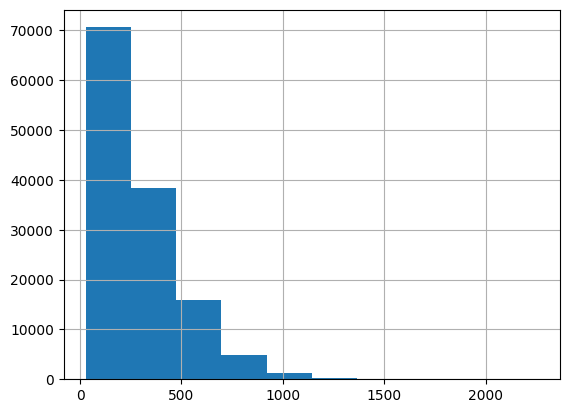

In [7]:
df_preproc["tokenized"] = X.map(lambda x: tokenizer(x)["input_ids"])

df_preproc["len_tokenized"] = X.map(lambda x: len(x))

df_preproc["len_tokenized"].hist()

In [11]:
sample_size = 1_000
# $CHALLENGIFY_BEGIN
tokenized_tensors = tokenizer(X[0:sample_size].tolist(), max_length=50, padding = "max_length", truncation = True, return_tensors="tf")
# $CHALLENGIFY_END

In [12]:
tokenized_tensors.input_ids.shape

TensorShape([1000, 50])

In [13]:
#embeddings = model.predict(tokenized_tensors["input_ids"])

# Process the data in smaller batches
batch_size = 1000
embeddings = []
for i in range(0, sample_size, batch_size):
  batch_tensors = {k: v[i:i+batch_size] for k, v in tokenized_tensors.items()}
  batch_embeddings = model.predict(batch_tensors)
  embeddings.append(batch_embeddings)

# Concatenate the embeddings from all batches if necessary
#embeddings = np.concatenate(embeddings, axis=0)

32/32 [==============================] - 56s 2s/step


In [68]:
embeddings[0:2]

[TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=array([[[ 0.0532216 ,  0.04991533,  0.11046433, ..., -0.10858361,
           0.03737129,  0.01106982],
         [ 0.07157488, -0.07916652,  0.19290388, ...,  0.04103545,
           0.03665847,  0.00314953],
         [ 0.01561672,  0.1242684 ,  0.09406839, ..., -0.12447987,
          -0.07138798,  0.07295808],
         ...,
         [ 0.12353781, -0.4236256 ,  0.11867408, ..., -0.01154631,
           0.04105398,  0.05313944],
         [ 0.10628681,  0.37706286,  0.03471105, ..., -0.05813531,
           0.11697111,  0.08601231],
         [ 0.00896474,  0.08237365,  0.12580264, ..., -0.07772678,
          -0.00794704, -0.01098449]],
 
        [[ 0.0573686 , -0.11006868,  0.07004149, ..., -0.07074985,
           0.00697343,  0.06330613],
         [-0.04865991,  0.28864408,  0.15087992, ...,  0.06994699,
           0.04030158,  0.10710821],
         [-0.07784609,  0.03689325, -0.01827803, ..., -0.02139324,
           0.051810

In [14]:
nb_batches = int(round(sample_size / batch_size,0))
embeddings_all = np.concatenate([embeddings[x].last_hidden_state[:,0,:] for x in range(nb_batches)], axis=0)

In [15]:
embeddings_all.shape

(1000, 768)

In [16]:
#X_sample = embeddings.last_hidden_state[:,0,:]
X_sample = embeddings_all
y_sample = y_encoded[0:sample_size]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 768), (200, 768), (800,), (200,))

In [26]:
label_dim = len(label_encoder.classes_)
label_dim

4

In [74]:
# $CHALLENGIFY_BEGIN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

input_shape = (768,)

dense_model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(8, activation='softmax')
])

dense_model.summary()
# $CHALLENGIFY_END

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 256)               196864    
                                                                 
 flatten_7 (Flatten)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 198,920
Trainable params: 198,920
Non-trainable params: 0
_________________________________________________________________


In [75]:
patience_ = 5
epoch_=100
early_stopper = EarlyStopping(monitor='val_loss', patience=patience_, restore_best_weights=True)

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

dense_model.fit(X_train, y_train, validation_split=0.2, epochs=epoch_, batch_size=32, callbacks=[early_stopper])

dense_model.evaluate(X_test, y_test)

Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 1.1043 - accuracy: 0.4664 - val_loss: 1.0644 - val_accuracy: 0.5131
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0571 - accuracy: 0.4986 - val_loss: 1.0409 - val_accuracy: 0.5181
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0461 - accuracy: 0.5066 - val_loss: 1.0465 - val_accuracy: 0.5006
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0418 - accuracy: 0.5048 - val_loss: 1.0434 - val_accuracy: 0.5069
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0306 - accuracy: 0.5133 - val_loss: 1.0493 - val_accuracy: 0.5044
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0200 - accuracy: 0.5206 - val_loss: 1.0412 - val_accuracy: 0.5150
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 1.0162 - accuracy: 0.5256 - val_loss: 1.0372 - val_accuracy: 0.5169

[1.006202220916748, 0.5249999761581421]

In [20]:
# Prédire sur l'ensemble de test
y_pred = model_bert.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

1/7 [===>..........................] - ETA: 0s

7/7 [==============================] - 0s 2ms/step


In [25]:
y_pred_classes.shape

(200,)

In [ ]:
# Afficher le rapport de classification
print("Rapport de classification pour le Dense avec Bert:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

In [78]:
models_dir=f'data/models/{timestamp()}'
os.makedirs(models_dir, exist_ok=True)
model_path = models_dir+"/bert-{epoch:04d}.keras"
save_model(dense_model, model_path, overwrite=True)


In [2]:
model_bert = load_model("data/models/2024-08-28-113853/bert-{epoch:04d}.keras")

2024-08-28 11:42:19.012178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
X_pred = "Nous devons améliorer la politique d'aide aux entreprises"

IndexError: tuple index out of range

In [ ]:
# Prédire sur l'ensemble de test
y_pred = model_bert.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher le rapport de classification
print("Rapport de classification pour le Dense avec Bert:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

## Other structure

In [16]:
# Construire le modèle RNN avec LSTM
#embedding_dim = embedding_dim_
input_shape = (768, 50)
patience_ = 5
epoch_=5

early_stopper = EarlyStopping(monitor='val_loss', patience=patience_, restore_best_weights=True)

model = Sequential()
#model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
#model.add(SpatialDropout1D(0.2))
model.add(Masking(input_shape=input_shape))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

# Compiler le modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Afficher un résumé du modèle
print(model.summary())

NameError: name 'y_encoded' is not defined

In [ ]:
# Entraîner le modèle
batch_size = 64
epochs = epoch_

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopper],
    verbose=1
)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher le rapport de classification
print("Rapport de classification pour le Dense avec Bert:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

Epoch 1/5


ValueError: in user code:

    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/bouzelfi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_6" "                 f"(type Sequential).
    
    Input 0 of layer "dense_12" is incompatible with the layer: expected axis -1 of input shape to have value 50, but received input with shape (None, 1)
    
    Call arguments received by layer "sequential_6" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=string)
      • training=True
      • mask=None


In [26]:
# Create model
input_shape = (768,)
model_bert = Sequential([
Dense(256, activation='relu', input_shape=input_shape),
Flatten(),
Dense(8, activation='softmax')
])

model_bert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_bert.load_weights('/home/bouzelfi/code/Rendalae/harrisvstrump/data/checkpoints/2024-08-27-173851/Bert/cp-0013.weights.ckpt')

2024-08-28 10:25:10.328341: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /home/bouzelfi/code/Rendalae/harrisvstrump/data/checkpoints/2024-08-27-173851/Bert/cp-0013.weights.ckpt: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


ValueError: Layer count mismatch when loading weights from file. Model expected 2 layers, found 0 saved layers.

In [ ]:
mapping_political_people = {
    "Centre": ["Emmanuel Macron", "Bayrou", "Brigitte Macron"],
    "Droite": ["Nicolas Sarkozy", "François Fillon", "Eric Ciotti"],
    "Gauche": ["François Hollande", "Melenchon", "Marine Le Pen"]
}